# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

## Table of Contents
    
    1. Commodity ETFs - entire workflow application example

### Import Libraries

In [69]:
import numpy as np
import pandas as pd
import pickle

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# just set the seed for the random number generator
np.random.seed(107)

In [70]:
config_file = 'config/config_commodities_2010_2019.json'

### Import Configurations

In [71]:
with open(config_file, 'r') as f:
    config = json.load(f)

### Import Classes

In [72]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# 1. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [74]:
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_long_updated')

In [75]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            (config['dataset']['training_initial_date'],
                                                             config['dataset']['training_final_date']),
                                                            (config['dataset']['testing_initial_date'],
                                                             config['dataset']['testing_final_date']),
                                                            remove_nan=True)

Total of 208 tickers
Total of 77 tickers after removing tickers with Nan values


In [76]:
len(df_prices_train)+len(df_prices_test)

2264

## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

**Obtain returns**

In [77]:
df_returns = data_processor.get_return_series(df_prices_train)
df_returns.head()

,AGQ,AMJ,CGW,DBA,DBB,DBC,DBE,DBO,DBP,DBS,...,UNL,USL,USO,USV,VDE,XES,XLE,XME,XOP,ZSL
2010-01-05,0.031780,0.013699,0.002137,0.006369,0.006981,0.001189,0.000000,0.009256,0.003004,0.016325,...,-0.029202,0.009024,0.003477,0.023771,0.010236,0.024763,0.008162,0.014386,0.008345,-0.031746
2010-01-06,0.041175,0.000676,-0.004797,0.005585,0.031196,0.017808,0.014665,0.012346,0.017142,0.019843,...,0.035583,0.012965,0.013858,0.014634,0.011514,0.019199,0.011975,0.039273,0.011264,-0.044496
2010-01-07,0.002912,-0.012492,-0.002678,-0.007775,-0.028571,-0.012442,-0.004129,-0.006969,-0.004315,0.002779,...,-0.013990,-0.007585,-0.006102,0.019227,-0.002390,0.000650,-0.001500,-0.007348,-0.005910,0.000000
2010-01-08,0.028809,0.015726,0.017186,0.002985,-0.007785,-0.000787,0.000370,0.004912,0.006628,0.014475,...,-0.013203,0.004538,0.005157,0.003023,0.007531,0.021097,0.006510,0.035072,0.007775,-0.026961
2010-01-11,0.007131,-0.010434,0.006864,-0.004464,0.009590,-0.003152,-0.010363,-0.005587,0.010889,0.004554,...,-0.033221,-0.007608,-0.009528,0.004138,-0.000793,-0.015257,-0.001327,-0.014303,-0.011119,-0.015113


In [78]:
print('Total number of possible pairs: ', len(df_returns.columns)*(len(df_returns.columns)-1)/2)

Total number of possible pairs:  2926.0


**Applying PCA on Returns**

- Protecting from `Curse of Dimensionality` - *source: https://stats.stackexchange.com/questions/232500/how-do-i-know-my-k-means-clustering-algorithm-is-suffering-from-the-curse-of-dim*: Perform a principle components analysis (PCA) and look at how the eigenvalues drop off. It is quite common that most of the variation exists in a couple of dimensions (which typically cut across the original dimensions of your dataset)

To analyze how many principal components we should be using, and accounting for the fact that too many features might incur curse of dimensionality, we proceed to visualize the explanatory power of the first 20 features. We observe that most of the information is in fact contained within the first features. We choose to keep the first 14.

In [79]:
# this show us the feature importance of the 
N_PRIN_COMPONENTS = 20
_, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)
print(explained_variance)

[1.56802426e-02 5.77585478e-03 2.24341677e-03 9.18763070e-04
 8.31002568e-04 7.63191182e-04 5.61156857e-04 4.31498158e-04
 3.69145191e-04 2.73017929e-04 2.44440985e-04 2.33108309e-04
 2.19768726e-04 1.64100025e-04 1.53159762e-04 1.40104140e-04
 1.26549198e-04 1.17457032e-04 1.06117902e-04 9.80481747e-05]


In [80]:
N_PRIN_COMPONENTS = 8#config['PCA']['N_COMPONENTS']
X, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)

**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [81]:
clustered_series_all, clustered_series, counts, clf = series_analyser.apply_DBSCAN(config['clustering']['epsilon'],
                                                                                   config['clustering']['min_samples'],
                                                                                   X,
                                                                                   df_returns)

Clusters discovered: 12
Pairs to evaluate: 132


The epsilon parameter strongly dependens on the data. Because of the that, it is not obvious wether DBSCAN is the best algo.

In [82]:
print(counts)

11    13
2      6
6      5
0      5
4      4
8      3
5      3
1      3
10     2
9      2
7      2
3      2
dtype: int64


### Optimize according to Silhouette

When performing PCA, use number of components that maximizes the silhouette coefficient after clustering.

In [83]:
X, clustered_series_all, clustered_series, counts, clf = series_analyser.clustering_for_optimal_PCA(10,
                                                                                  20,
                                                                                  df_returns,
                                                                                  config['clustering'])


Number of components:  10
Returns shape:  (2012, 77)
Clusters discovered: 13
Pairs to evaluate: 64
Silhouette score  0.13380036484790464

Number of components:  11
Returns shape:  (2012, 77)
Clusters discovered: 13
Pairs to evaluate: 60
Silhouette score  0.12096348979631441

Number of components:  12
Returns shape:  (2012, 77)
Clusters discovered: 14
Pairs to evaluate: 36
Silhouette score  0.07075809013095002

Number of components:  13
Returns shape:  (2012, 77)
Clusters discovered: 13
Pairs to evaluate: 24
Silhouette score  -0.019439565255229312

Number of components:  14
Returns shape:  (2012, 77)
Clusters discovered: 11
Pairs to evaluate: 18
Silhouette score  -0.06403872281681748

Number of components:  15
Returns shape:  (2012, 77)
Clusters discovered: 9
Pairs to evaluate: 16
Silhouette score  -0.09758706086543599

Number of components:  16
Returns shape:  (2012, 77)
Clusters discovered: 9
Pairs to evaluate: 16
Silhouette score  -0.0948367456893342

Number of components:  17
Retur

**Fundamental analysis for clusters**

In [84]:
etfs, etfs_unique, tickers = \
            data_processor.read_ticker_excel(path='data/etfs/commodity_ETFs_long_updated.xlsx')

In [85]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
    Ticker                        Segment
375    CGW           Equity: Global Water
376    FIW           Equity: Global Water
277    NLR  Equity: Global Nuclear Energy
374    PHO           Equity: Global Water
377    PIO           Equity: Global Water

Cluster 1:
    Ticker                    Segment
26     DBC  Commodities: Broad Market
134    RJI  Commodities: Broad Market
65     UCI  Commodities: Broad Market

Cluster 2:
    Ticker              Segment
61     DBE  Commodities: Energy
135    RJN  Commodities: Energy

Cluster 3:
   Ticker                        Segment
41    DBO  Commodities: Energy Crude Oil
66    USL  Commodities: Energy Crude Oil
27    USO  Commodities: Energy Crude Oil

Cluster 4:
   Ticker                              Segment
96    DBS  Commodities: Precious Metals Silver
40   SIVR  Commodities: Precious Metals Silver
24    SLV  Commodities: Precious Metals Silver

Cluster 5:
   Ticker                            Segment
59    DGL  Commodities: Preciou

**Visualizing with t-sne**

In [86]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X) 
    
    # visualization
    plt.figure(1, facecolor='white', figsize=(15,5))
    plt.clf()
    plt.axis('off')

    labels = clf.labels_
    plt.scatter(
        X_tsne[(labels!=-1), 0],
        X_tsne[(labels!=-1), 1],
        s=100,
        alpha=0.85,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )

    plt.scatter(
        X_tsne[(clustered_series_all==-1).values, 0],
        X_tsne[(clustered_series_all==-1).values, 1],
        s=100,
        alpha=0.10
    )

    plt.title('T-SNE of all ETFs with DBSCAN Clusters Noted');

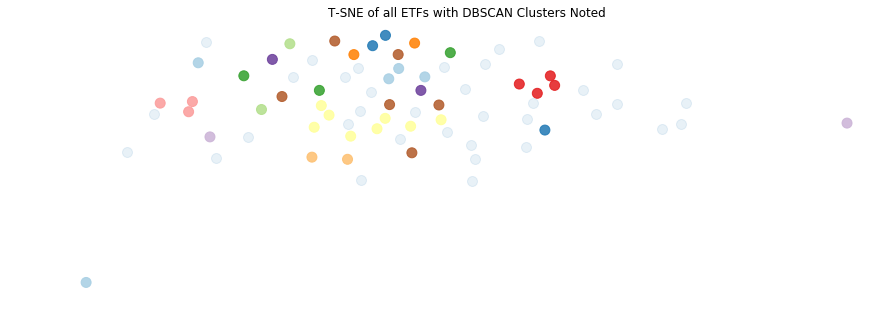

In [87]:
plot_TSNE(X,clf, clustered_series_all)

What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

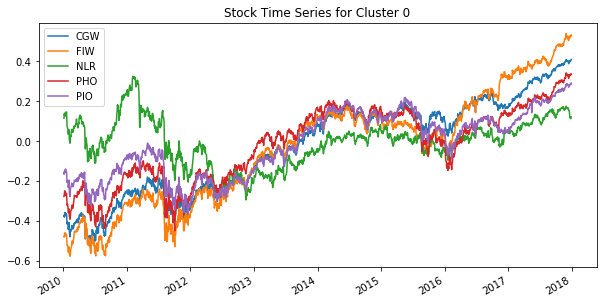

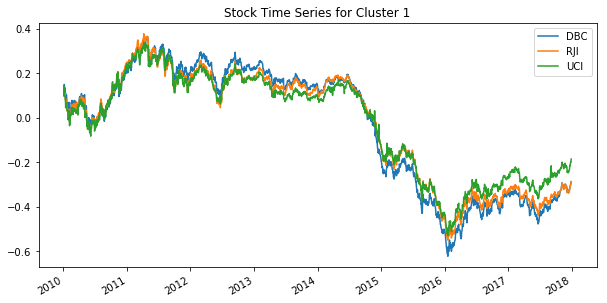

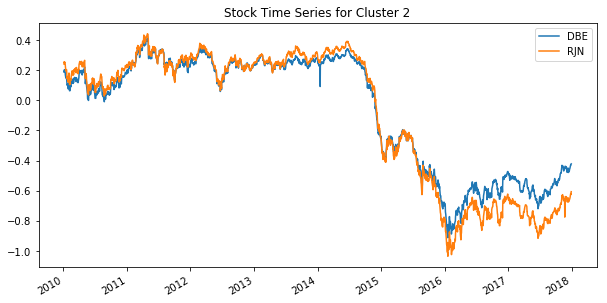

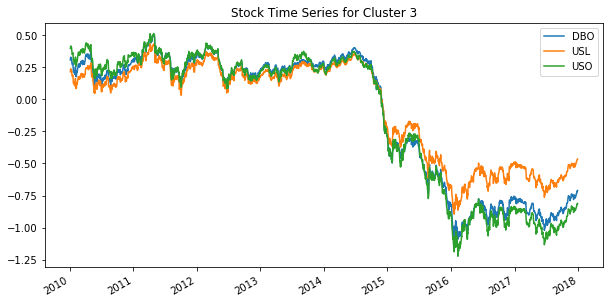

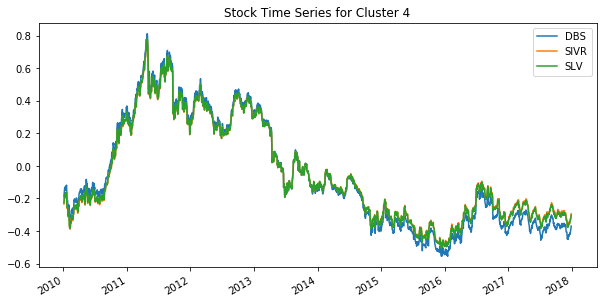

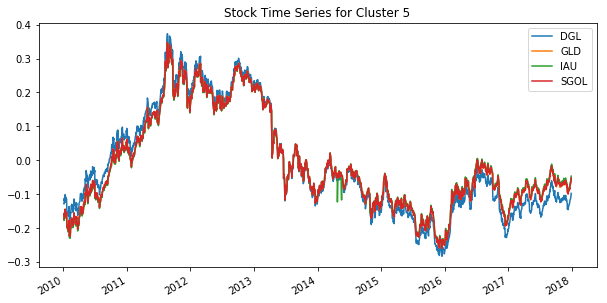

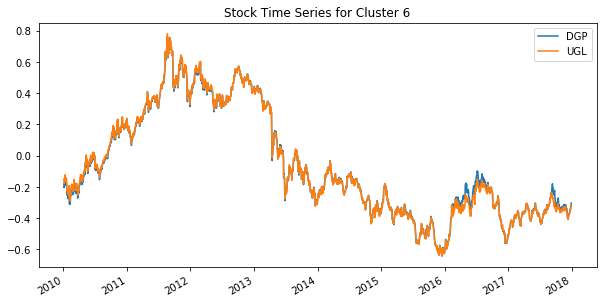

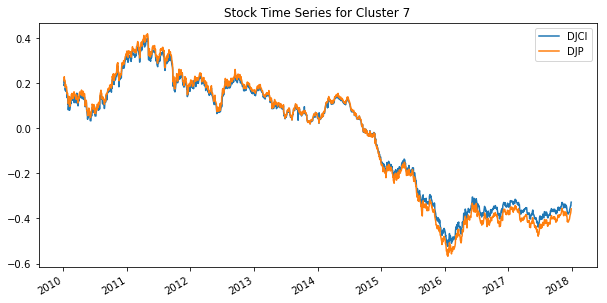

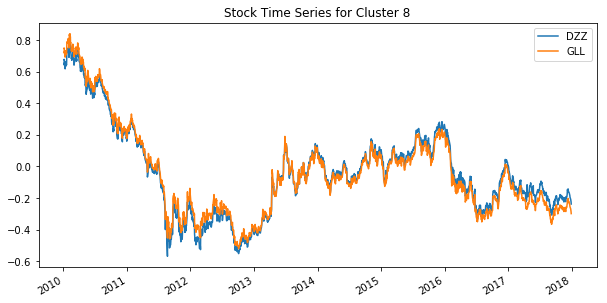

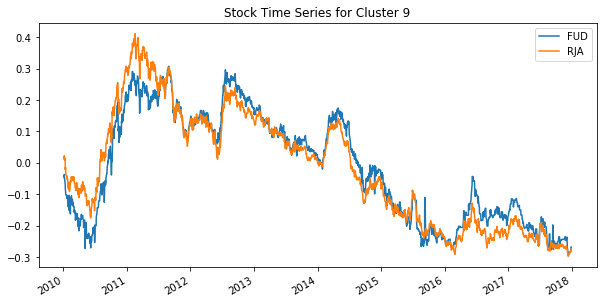

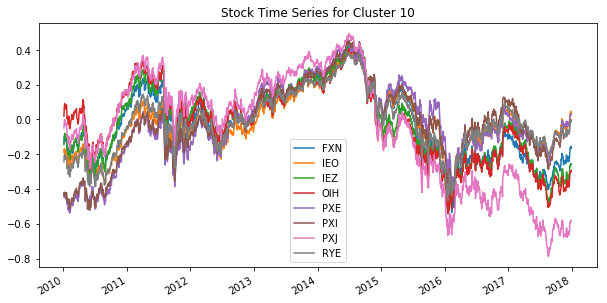

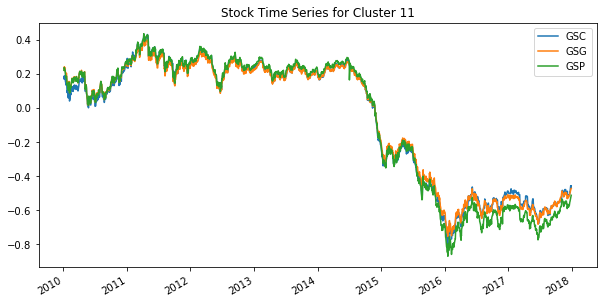

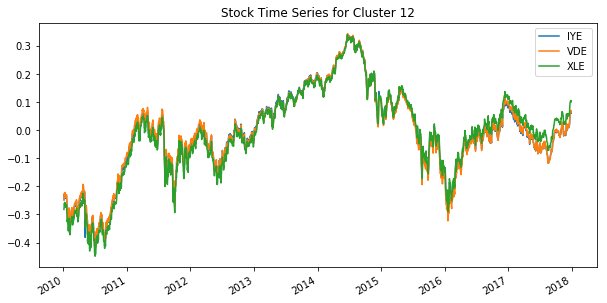

In [88]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(df_prices_train[symbols].mean())
    series = np.log(df_prices_train[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [89]:
pairs, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )

Found 7 pairs
The pairs contain 11 unique tickers


In [90]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

In [91]:
n_years_train = round(len(df_prices_train)/240)

**Applying Bollinger Bands**

In [92]:
sharpe_results_bollinger, cum_returns_bollinger, performance_bollinger = trader.apply_bollinger_strategy(pairs,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter,
                                                                                         test_mode=False
                                                                                         )

**Bollinger Bands Performance**

In [93]:
avg_sharpe_bollinger, total_roi_bollinger, anual_roi_bollinger, positive_pct_bollinger = \
    trader.calculate_metrics(sharpe_results_bollinger, cum_returns_bollinger, n_years_train)

Average result:  0.5580096589717671
avg_total_roi:  7.686506405185351
avg_annual_roi:  0.9299739033736154
71.42857142857143 % of the pairs had positive returns


**Applying the Kalman filter based strategy**

In [94]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=False)

In [95]:
avg_sharpe_kalman, total_roi_kalman, anual_roi_kalman, positive_pct_kalman = \
    trader.calculate_metrics(sharpe_results_kalman, cum_returns_kalman, n_years_train)

Average result:  3.467018659192462
avg_total_roi:  41.27115604742188
avg_annual_roi:  4.41350807359846
100.0 % of the pairs had positive returns


Sharpe Ratio Distribution: 


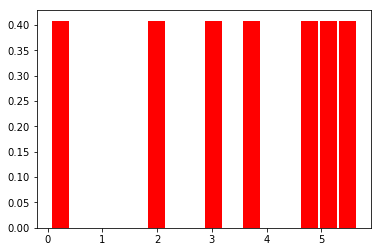

In [96]:
print('Sharpe Ratio Distribution: ')
n, bins, patches = plt.hist(sharpe_results_kalman, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')

## Some remarks

- From the analysis above, the Kalman filter method obtains the best performance, with an average Sharpe Ratio larger than 1.
- We should compare this approach with a *compare all against all* approach, to see by which factor our results are improved due to the clustering technique.

# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [97]:
n_years_test = round(len(df_prices_test)/240)

### Approach 1: Keeping every pair

**Bollinger Bands Out-of-Sample**

In [98]:
sharpe_results_bollinger_test, cum_returns_bollinger_test, performance_bollinger_test =\
                                    trader.apply_bollinger_strategy(pairs,
                                                                    lookback_multiplier,
                                                                    entry_multiplier,
                                                                    exit_multiplier,
                                                                    trading_filter,
                                                                    test_mode = True
                                                                    )

In [99]:
avg_sharpe_bollinger_test, total_roi_bollinger_test, anual_roi_bollinger_test, positive_pct_bollinger_test = \
    trader.calculate_metrics(sharpe_results_bollinger_test, cum_returns_bollinger_test, n_years_test)

Average result:  0.6058308283149555
avg_total_roi:  3.2297179255389823
avg_annual_roi:  3.2297179255389885
71.42857142857143 % of the pairs had positive returns


**Kalman Out-of-Sample**

In [100]:
sharpe_results_kalman_test, cum_returns_kalman_test, performance_kalman_test = trader.apply_kalman_strategy(pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True)

In [101]:
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
        trader.calculate_metrics(sharpe_results_kalman_test, cum_returns_kalman_test, n_years_test)

Average result:  1.8328957113556754
avg_total_roi:  18.122494691830195
avg_annual_roi:  18.122494691830184
100.0 % of the pairs had positive returns


### Approach 2: Keeping only pairs that had positive returns in the training period

**Bollinger Strategy**

In [102]:
sharpe_results_bollinger = np.asarray(sharpe_results_bollinger)
profitable_pairs_indices = np.argwhere(sharpe_results_bollinger > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [103]:
sharpe_results_bollinger_test, cum_returns_bollinger_test, performance_bollinger_test =\
                                    trader.apply_bollinger_strategy(profitable_pairs,
                                                                    lookback_multiplier,
                                                                    entry_multiplier,
                                                                    exit_multiplier,
                                                                    trading_filter,
                                                                    test_mode = True)

In [104]:
avg_sharpe_bollinger_test, total_roi_bollinger_test, anual_roi_bollinger_test, positive_pct_bollinger_test = \
    trader.calculate_metrics(sharpe_results_bollinger_test, cum_returns_bollinger_test, n_years_test)

Average result:  0.6506939254327068
avg_total_roi:  1.3885330959942244
avg_annual_roi:  1.3885330959942266
80.0 % of the pairs had positive returns


**Kalman Strategy**

In [105]:
sharpe_results_kalman = np.asarray(sharpe_results_kalman)
profitable_pairs_indices = np.argwhere(sharpe_results_kalman > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [106]:
sharpe_results_kalman_test, cum_returns_kalman_test, performance_kalman_test = trader.apply_kalman_strategy(\
                                                                                             profitable_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True)

In [107]:
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
    trader.calculate_metrics(sharpe_results_kalman_test, cum_returns_kalman_test, n_years_test)

Average result:  1.8328957113556754
avg_total_roi:  18.122494691830195
avg_annual_roi:  18.122494691830184
100.0 % of the pairs had positive returns


We can conclude that the 2nd approach presents better results. From now on, we assume the 2nd approach was taken.

# Validate the results

The results obtained are suspiciously high. We pretend to look deeper into the numbers.

In [108]:
with open(config['dataset']['ticker_segment_dict'], 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)
results, pairs_summary = trader.summarize_results(sharpe_results_kalman_test, cum_returns_kalman_test,
                                                  performance_kalman_test, profitable_pairs, ticker_segment_dict)

Average result:  1.8328957113556754
avg_total_roi:  18.122494691830195
avg_annual_roi:  18.122494691830184
100.0 % of the pairs had positive returns


In [109]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,GSC,Commodities: Broad Market,GSG,Commodities: Broad Market,-3.710248,0.003971,191,10,0.227213,49,5,3.143045,90.740741
1,DBO,Commodities: Energy Crude Oil,USL,Commodities: Energy Crude Oil,-3.481166,0.008484,99,34,0.436664,12,2,2.770154,85.714286
2,GSC,Commodities: Broad Market,GSP,Commodities: Broad Market,-3.361991,0.012325,225,6,0.178382,51,5,2.703849,91.071429
3,PXI,Equity: U.S. Energy,RYE,Equity: U.S. Energy,-2.929774,0.041994,117,64,0.400400,37,13,1.298070,74.000000
4,IEO,Equity: U.S. Oil & Gas Exploration & Production,PXI,Equity: U.S. Energy,-3.520323,0.007480,74,60,0.400022,27,10,1.132084,72.972973
5,DGP,Leveraged Commodities: Precious Metals Gold,UGL,Leveraged Commodities: Precious Metals Gold,-3.791599,0.002994,111,16,0.322583,2,0,1.113220,100.000000
6,DBO,Commodities: Energy Crude Oil,USO,Commodities: Energy Crude Oil,-3.557897,0.006619,59,74,0.475717,11,4,0.669848,73.333333


In [41]:
performance_bollinger_test[4][1][38:]

,pnl,ret,SOYB,BCM,beta,spread,zscore,current_position,position_return_(%)
2018-02-27,0.000000,0.000000,19.0500,29.6632,0.076840,16.770678,NaN,0.0,0.000000
2018-02-28,0.000000,0.000000,19.1200,29.3734,0.146281,14.823242,0.356708,0.0,0.000000
2018-03-01,0.000000,0.000000,19.3100,29.2405,0.156788,14.725452,0.277921,0.0,0.000000
2018-03-02,0.000000,0.000000,19.3300,29.3800,0.168053,14.392615,0.160463,0.0,0.000000
2018-03-05,0.000000,0.000000,19.4500,29.5690,0.360700,8.784471,-0.629574,0.0,0.000000
2018-03-06,-0.000000,0.000000,19.4150,29.7100,0.602700,1.508793,-1.656209,0.0,0.000000
2018-03-07,0.058180,0.001559,19.2500,29.3397,0.729746,-2.160524,-2.133650,1.0,0.000000
2018-03-08,0.063702,0.001567,19.2300,29.2250,0.767659,-3.204837,-2.161876,1.0,0.000000
2018-03-09,-0.483885,-0.011614,18.9150,29.4450,0.690217,-1.408427,-1.783096,1.0,0.000000
2018-03-12,0.143219,0.003650,18.9961,29.3550,0.605613,1.218321,-1.341336,1.0,0.000000


In [117]:
performance_bollinger_test[4][1][38:]

,pnl,ret,GSP,GSC,beta,spread,zscore,current_position,position_return_(%)
2018-02-27,0.161000,0.005593,15.8190,24.5410,0.632875,0.287608,0.078599,-1.0,0.000000
2018-02-28,0.289000,0.009218,15.5300,24.5410,0.655330,-0.552456,-0.232226,-1.0,-0.376119
2018-03-01,0.000000,0.000000,15.5000,24.0000,0.553378,2.218926,0.607409,0.0,0.000000
2018-03-02,-0.000000,0.000000,15.4800,24.0000,0.496470,3.564712,0.951047,0.0,0.000000
2018-03-05,0.000000,0.000000,15.7110,24.0000,0.375156,6.707258,1.744652,0.0,0.000000
2018-03-06,0.073547,0.002976,15.7500,24.3000,0.240853,9.897265,2.111931,-1.0,0.000000
2018-03-07,0.240796,0.011147,15.5080,24.2950,0.218812,10.191967,1.733701,-1.0,0.000000
2018-03-08,0.092803,0.004457,15.3594,24.0400,0.214884,10.193600,1.440984,-1.0,0.000000
2018-03-09,-0.203275,-0.009904,15.6000,24.2137,0.376850,6.475072,0.362305,-1.0,0.000000
2018-03-12,0.130100,0.005262,15.4699,24.2137,0.497381,3.426466,-0.431901,-1.0,1.389361


In [42]:
performance_kalman_test[10][1]

,pnl,ret,DBA,TAGS,beta,e,sqrt(Q),current_position,position_return_(%)
Date,,,,,,,,,
2018-01-02,NaN,0.000000,18.770665,22.4700,0.000000,18.770665,0.031623,0.0,0.000000
2018-01-03,0.000000,0.000000,18.760771,22.4700,0.817125,18.760771,0.227146,0.0,0.000000
2018-01-04,0.000000,0.000000,18.731086,22.4700,0.831674,0.333930,0.229294,0.0,0.000000
2018-01-05,0.000000,0.000000,18.632137,22.4700,0.827640,-0.092598,0.229295,0.0,0.000000
2018-01-08,0.000000,0.000000,18.503503,22.4700,0.821958,-0.130395,0.229295,0.0,0.000000
2018-01-09,0.000000,0.000000,18.543082,22.4700,0.823575,0.037100,0.229295,0.0,0.000000
2018-01-10,0.000000,0.000000,18.473818,22.3600,0.824539,0.022034,0.228196,0.0,0.000000
2018-01-11,0.000000,0.000000,18.404553,22.1515,0.829092,0.103075,0.226134,0.0,0.000000
2018-01-12,0.000000,0.000000,18.364974,22.1515,0.827432,-0.037564,0.226173,0.0,0.000000


**Controlling for range of returns**

In [43]:
print('Maximum return obtained in a single trade, per pair')
for i in range(len(profitable_pairs)):
    print(performance_kalman_test[i][1]['position_return_(%)'].max())

Maximum return obtained in a single trade, per pair
1.6946123163708693
2.505899170251258
1.4097409016118556
2.1338430897533733
1.6860522784658327
1.0425194102006152
2.054833774069764
0
1.1358655427785358
1.5474263527007093
4.837041157433486
1.2087901387847655
1.2996098044427695
2.0149815929791703
3.646007819933672
1.4869208113964971
1.763316563992845
2.059772822376038
1.806935696337253
1.5431466122493243
1.0767028815507729
1.9846759279724235
1.98345263450177
4.963191236212139
1.9120529726824431
1.127969296244724
1.339603219609664
2.466229846863466
2.2900974202672675
5.100732310556388
1.5912214006452041
5.285311934951409
1.698734733560392
1.0254646600236894
1.7750529197507303
0
1.574602557150273
0.4523774652568813
0.9283107797022572
0.5567364222407445
0.19828507758714586


In [44]:
print('Worst return obtained in a single trade, per pair')
for i in range(len(profitable_pairs)):
    print(performance_kalman_test[i][1]['position_return_(%)'].min())

Worst return obtained in a single trade, per pair
0.0
-0.03898631743475267
-0.8666528259521855
-0.5557883936601171
-1.5394115691793275
-0.7605602357658614
-2.111547984444484
0
-1.7127939561846994
-1.8756780715404653
-1.0718682047711092
-1.9666305612602963
-1.70524894202696
-2.4449091481068774
-1.1270335889943972
-0.5939794891703931
-2.5292814922177276
-1.1060010727740544
-1.3679391044775002
-1.09435987833435
-1.716908630159475
-1.9214497234602668
-1.7707414349692474
-0.3706235624404641
-2.894272781633167
-1.6085203662937309
-0.517282180567491
-1.3941386926228039
-1.4131012872760862
0.0
-3.3149641040919997
-1.9627068995084485
-3.217342722452321
-1.509843199222216
-4.049489483001212
0
-1.9388865168872838
-0.5009205463778588
0.0
-0.8099995090938727
0.0


Tanto as returns máximas como as mínimas parecem ter valores dentro da normalidade.

## Training vs Validation

For a far comparison, we should compare the test resuls with the results obtained in the training set, but also using only the profitable pairs:

In [45]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(profitable_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=False)
avg_sharpe_kalman, total_roi_kalman, anual_roi_kalman, positive_pct_kalman = \
    trader.calculate_metrics(sharpe_results_kalman, cum_returns_kalman, n_years_train)

Average result:  2.733475477230469
avg_total_roi:  43.77295172433407
avg_annual_roi:  12.86494207661837
100.0 % of the pairs had positive returns


In [46]:
print('The sharpe ratio obtained in the training set with the pairs used on the test set is ', avg_sharpe_kalman)
print('The sharpe ratio obtained in the test set is ', avg_sharpe_kalman_test)

The sharpe ratio obtained in the training set with the pairs used on the test set is  2.733475477230469
The sharpe ratio obtained in the test set is  1.7777807463022957


As expected, the sharpe ratio is indeed higher in the training set.

In [47]:
len(pairs)

48

In [48]:
len(profitable_pairs)

41

## Analyzing Pairs' Overlap

There could be two possible interpretations for pairs' overlap.
1. We might be interested in checking which of the cointegrated pairs found in the training dataset are also cointegrated in the test set; Furthermore we want to explore how the two types of pairs perform.
2. We might be interested in finding if the pairs that would have been found in the test set by performing PCA + clustering would be cointegrated in the training set.

Starting with **1)**, let's see how many of the identified pairs actually turned out to be cointegrated during this period.

In [49]:
pairs_overlapped, pairs_overlapped_index = series_analyser.pairs_overlap(pairs,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs identified in the training set are also cointegrated in the test set'.format(\
    len(pairs_overlapped), len(pairs)))

3 of the 48 pairs identified in the training set are also cointegrated in the test set


In [50]:
profitable_pairs_overlapped, profitable_pairs_overlapped_index = series_analyser.pairs_overlap(profitable_pairs,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs with positive returns identified in the training set are also cointegrated in the test set'.format(\
    len(profitable_pairs_overlapped), len(profitable_pairs)))

3 of the 41 pairs with positive returns identified in the training set are also cointegrated in the test set


### Is cointegration really important?

To answer this question we will see how many of the still cointegrated pairs had positive and negative returns. We will then do the same for those pairs that were not cointegrated. 

If both are as likely to have positive and negative returns, then it means cointegration is not as important of a condition. On the other hand, if we verify that all pairs that are still cointegrated turned out to be profitable and those that are not anymore led to consistent negative returns, we can infer that cointegration is a very important predictor of future returns.

We also compare the average performance of the two groups two see the relevance of being cointegrated with respect to the sharpe ratio obtained.

*Still cointegrated*

In [51]:
# distribution for pairs which were cointegrated in train and test
sharpe_results_pairs_overlapped = np.asarray([sharpe_results_kalman_test[index] for index \
                                              in profitable_pairs_overlapped_index])
cum_returns_pairs_overlapped = np.asarray([cum_returns_kalman_test[index] for index \
                                              in profitable_pairs_overlapped_index])

if len(sharpe_results_pairs_overlapped)>0:
    _,_,_,_ = trader.calculate_metrics(sharpe_results_pairs_overlapped, cum_returns_pairs_overlapped,
                                   n_years_test)
else:
    print('0% of the pairs cointegrated in the train are also cointegrated in the test set')

Average result:  2.0306122805026914
avg_total_roi:  7.959087698875848
avg_annual_roi:  7.959087698875855
100.0 % of the pairs had positive returns


*Not cointegrated anymore*

In [52]:
# distribution for pairs which were cointegrated in train but not in test
profitable_pairs_not_overlapped_index = [i for i in np.arange(0,len(profitable_pairs))\
                                         if i not in profitable_pairs_overlapped_index]

sharpe_results_pairs_not_overlapped = np.asarray([sharpe_results_kalman_test[index] for index \
                                              in profitable_pairs_not_overlapped_index])

cum_returns_pairs_not_overlapped = np.asarray([cum_returns_kalman_test[index] for index \
                                              in profitable_pairs_not_overlapped_index])

_,_,_,_ = trader.calculate_metrics(sharpe_results_pairs_not_overlapped, cum_returns_pairs_not_overlapped,
                                   n_years_test)

Average result:  1.7578203620233168
avg_total_roi:  11.448074208382865
avg_annual_roi:  11.448074208382874
89.47368421052632 % of the pairs had positive returns


Answering to the first question we were concerned with, we verify that a cointegrated pair is indeed more likely to have a positive return. Furthermore, we can conclude from the results that being cointegrated implied that those pairs generated higher returns. 

**TO REVIEW:Conclusion**: The fact that a pair is not cointegrated anymore does not impact the results obained. In fact, we just concluded that betting solely on the cointegrated pairs would yield a worse result. Therefore, we should not spend much effort in detecting pairs that are no cointegrated anymore.

Following with point number **2)**, we proceed to analyze the performance of the pairs that woud have been identified in the testing period.

In [53]:
initial_test_date = config['dataset']['testing_initial_date']
final_teste_date = config['dataset']['testing_final_date']

# Get returns for test period
df_returns_test = data_processor.get_return_series(df_prices_test)

# APPLY PCA and CLUSTERING
range_n_components = config['PCA']['N_COMPONENTS']
X_test, clustered_series_all_test, clustered_series_test, counts_test, clf_test = \
            series_analyser.clustering_for_optimal_PCA(range_n_components[0], range_n_components[1],
                                                       df_returns_test, config['clustering'])
# Find pairs
pairs_test, unique_tickers_test = series_analyser.get_candidate_pairs(\
                                            clustered_series=clustered_series_test,
                                            pricing_df_train=df_prices_test,
                                            pricing_df_test=df_prices_train,
                                            n_clusters=len(counts_test),
                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                            )

# Finally, see overlap
pairs_overlapped, pairs_overlapped_index = series_analyser.pairs_overlap(pairs_test,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs identified in the test set are also cointegrated in the training set'.format(\
    len(pairs_overlapped), len(pairs_test)))


Number of components:  10
Returns shape:  (250, 142)
Clusters discovered: 16
Pairs to evaluate: 74
Silhouette score  -0.14819524476406648

Number of components:  11
Returns shape:  (250, 142)
Clusters discovered: 16
Pairs to evaluate: 55
Silhouette score  -0.1918134077190126

Number of components:  12
Returns shape:  (250, 142)
Clusters discovered: 15
Pairs to evaluate: 49
Silhouette score  -0.2211296167108505

Number of components:  13
Returns shape:  (250, 142)
Clusters discovered: 11
Pairs to evaluate: 43
Silhouette score  -0.22215061038170864

Number of components:  14
Returns shape:  (250, 142)
Clusters discovered: 11
Pairs to evaluate: 30
Silhouette score  -0.23085678460495804

The best silhouette coefficient was: -0.14819524476406648 for 10 principal components
Found 11 pairs
The pairs contain 17 unique tickers
1 of the 11 pairs identified in the test set are also cointegrated in the training set


Let's see if the pairs identified in the test period lead indeed to improved results:

In [54]:
sharpe_results_kalman_test_newpairs, cum_returns_kalman_test_newpairs, performance_kalman_test_newpairs =\
    trader.apply_kalman_strategy(pairs_test, entry_multiplier,exit_multiplier,trading_filter, test_mode=False)

_,_,_,_ = trader.calculate_metrics(sharpe_results_kalman_test_newpairs, cum_returns_kalman_test_newpairs,
                                   n_years_test)

Average result:  0.8646877494674051
avg_total_roi:  1.8082850225898246
avg_annual_roi:  1.8082850225898284
63.63636363636363 % of the pairs had positive returns


The sharpe ratio is higher in this scenatio. Note hoewever, that the annual ROI is not so high as the pairs identified previously. This might be linked with the fact that these pairs did not prove to be cointegrated for a period as long as the other and therefore the pairs might be less stable.

## Analyzing the influence of pairs statistics

It's interesting to analyze whether we could have used extra information from the pairs trading statistic, instead of considering it just as a pass or not pass test. `Law 2017` explore this concept on their paper (htey basically rank pairs according to a trade off between t-statistic and spread deviation from its mean). However, what we see below is that there is no obvious influence of any parameter in the performance of the corresponding pair.

In [55]:
pairs_summary.corr()[['sharpe_result', 'positive_trades_per_pair_pct']].loc[['t_statistic', 'p_value',
                                                                             'zero_cross', 'half_life',
                                                                             'hurst_exponent']]

,sharpe_result,positive_trades_per_pair_pct
t_statistic,0.023366,-0.202260
p_value,-0.012837,-0.260705
zero_cross,0.186646,0.159022
half_life,-0.543717,-0.513089
hurst_exponent,-0.307055,-0.205580


### The Correlation Filter

The correlation filter aims to track how the correlation between the two legs of tha pair is varing, and provide that information as input to the trading strategy.

In [54]:
example_pair = failed_pairs[2]

example_pair_leg1 = example_pair[0][0]
example_pair_leg2 = example_pair[0][1]

example_pair_prices = etfs_pricing[[example_pair_leg1, example_pair_leg2]]
example_pair_prices.plot(figsize=(15,5))


# proceed to calculate correlation
rolling_window = config['trading']['lookback_multiplier']*example_pair[0][2]['half_life']

# get returns
example_pair_returns = data_processor.get_return_series(example_pair_prices)

# analyze correlation on returns
example_correlation = example_pair_returns[example_pair_leg1].rolling(rolling_window).corr(example_pair_returns[example_pair_leg2])

# plot correlation of returns
diff_example_correlation = example_correlation.diff(periods=1)
#diff_example_correlation = diff_example_correlation*10
diff_example_correlation.plot()

NameError: name 'failed_pairs' is not defined

This result indicates there's almost no correlation between correlation diff and returns... Let's see how this result varies on average:

In [ ]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    correlation = failure_df['ret'].corr(failure_df['correlation'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

However, we are not realyy interested in the correlation of the the diff column, but rather on the correlation with its sign.

In [ ]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    failure_df['diff_correlation_sign']=failure_df['diff_correlation'].apply(lambda row: -1 if row<0 else 1)
    correlation = failure_df['ret'].corr(failure_df['diff_correlation_sign'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

We could use mutual information rather than correlation as the sign is discrete. What about the relation with the zscore evolution?

### Analyze non-profitable pairs

In [ ]:
sharpe_results_kalman_test = np.asarray(sharpe_results_kalman_test)
negative_pairs_indices = np.argwhere(sharpe_results_kalman_test < 0)
print('{} out of {} pairs turned out to be non-profitable'.format(len(negative_pairs_indices), len(pairs)))

Let's get some more information on the non-profitable pairs:

In [ ]:
negative_pairs = [pairs[i] for i in negative_pairs_indices.flatten()]
negative_pairs = [(item[0], item[1]) for item in negative_pairs]
negative_pairs

To what clusters do these pairs belong?

In [ ]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    for pair in negative_pairs:
        if pair[0] in list(etfs_cluster_n.Ticker):
            print('Pair {} belongs to cluster {}'.format(pair, label_n))

How do the statistics rank?

In [ ]:
sorted_indices = np.flip(np.argsort(sharpe_results_bollinger), axis=0)

# initialize list of lists 
data = []
for index in sorted_indices:
    # get number of positive and negative positions
    position_returns = performance_bollinger[index][1].position_return
    positive_positions = len(position_returns[position_returns>0])
    negative_positions = len(position_returns[position_returns<0])
    data.append([pairs[index][0],
                 pairs[index][1],
                 pairs[index][2]['t_statistic'],
                 pairs[index][2]['p_value'],
                 pairs[index][2]['zero_cross'],
                 pairs[index][2]['half_life'],
                 pairs[index][2]['hurst_exponent'],
                 positive_positions,
                 negative_positions,
                 sharpe_results_bollinger[index]
                ])
      
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Leg1', 'Leg2', 't_statistic', 'p_value', 'zero_cross',
                                   'half_life', 'hurst_exponent', 'positive trades', 'negative_trades',
                                   'sharpe_result']) 
df

In [ ]:
df.half_life.mean()

In [ ]:
# analyze correlations
print('Half-life vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['half_life']))
print('Zero crossings vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['zero_cross']))
print('p-value vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['p_value']))
print('t-statistic vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['t_statistic']))
print('Hurst exponent vs Sharpe Ratio correlation ', df['sharpe_result'].corr(df['hurst_exponent']))

Are there any signs these pairs were not profitable as the strategy evolves? Could we have predicted their lack of profitability?
- Using a ML algorithm that recognizes when a pair is not profitable anymore.
- Checking how the hurst exponent has been changing.
- Analyze their previous positions' returns

# What if we haven't done any clustering?

**All against all** - *comparing against the simplest strategy*

In [58]:
no_cluster_series = pd.Series(0,index = df_prices_train.columns)
pairs_all_a_all, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=no_cluster_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            n_clusters=1,
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )
pairs_found_all_a_all = len(pairs_all_a_all)
print('Found {} pairs'.format(pairs_found_all_a_all))

Found 2225 pairs
The pairs contain 142 unique tickers


NameError: name 'total_pairs_all_a_all' is not defined

**Bollinger Bands (train)**

In [60]:
sharpe_results_bollinger, cum_returns_bollinger, performance_bollinger = \
         trader.apply_bollinger_strategy(pairs_all_a_all,
                                         lookback_multiplier,
                                         entry_multiplier,
                                         exit_multiplier,
                                         trading_filter,
                                         test_mode=False
                                         )

avg_sharpe_bollinger, total_roi_bollinger, anual_roi_bollinger, positive_pct_bollinger = \
    trader.calculate_metrics(sharpe_results_bollinger, cum_returns_bollinger, n_years_train)

Average result:  0.20049034700226076
avg_total_roi:  5.585443939896273
avg_annual_roi:  1.828188247197593
57.93258426966292 % of the pairs had positive returns


**Bollinger Bands (test)**

In [62]:
sharpe_results_bollinger = np.asarray(sharpe_results_bollinger)
profitable_pairs_indices = np.argwhere(sharpe_results_bollinger > 0)
profitable_pairs = [pairs_all_a_all[i] for i in profitable_pairs_indices.flatten()]

sharpe_results_bollinger_test, cum_returns_bollinger_test, performance_bollinger_test =\
                                    trader.apply_bollinger_strategy(profitable_pairs,
                                                                    lookback_multiplier,
                                                                    entry_multiplier,
                                                                    exit_multiplier,
                                                                    trading_filter,
                                                                    test_mode = True)

avg_sharpe_bollinger_test, total_roi_bollinger_test, anual_roi_bollinger_test, positive_pct_bollinger_test = \
    trader.calculate_metrics(sharpe_results_bollinger_test, cum_returns_bollinger_test, n_years_test)

Average result:  -0.004589311632362016
avg_total_roi:  -1.2544244839101453
avg_annual_roi:  -1.2544244839101437
49.5733126454616 % of the pairs had positive returns


**Kalman filter (train)**

In [70]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(pairs_all_a_all, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=False)

avg_sharpe_kalman, total_roi_kalman, anual_roi_kalman, positive_pct_kalman = \
    trader.calculate_metrics(sharpe_results_kalman, cum_returns_kalman, n_years_train)

Average result:  0.4020397946508652
avg_total_roi:  16.886420403252508
avg_annual_roi:  5.338715819326567
58.337078651685395 % of the pairs had positive returns


**Kalman filter (test)**

In [71]:
sharpe_results_kalman = np.asarray(sharpe_results_kalman)
profitable_pairs_indices = np.argwhere(sharpe_results_kalman > 0)
profitable_pairs = [pairs_all_a_all[i] for i in profitable_pairs_indices.flatten()]

sharpe_results_kalman_test, cum_returns_kalman_test, performance_kalman_test = trader.apply_kalman_strategy(\
                                                                                             profitable_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True)

avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
    trader.calculate_metrics(sharpe_results_kalman_test, cum_returns_kalman_test, n_years_test)

Average result:  1.0857497110268213
avg_total_roi:  16.243251430984955
avg_annual_roi:  16.24325143098495
85.59322033898304 % of the pairs had positive returns


In [84]:
pairs_summary

,Leg1,Leg2,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,ATMP,YMLI,-3.534003,0.007156,89,6,0.236072,71,13,4.997857,84.523810
1,GRU,RJA,-3.158854,0.022493,62,25,0.363095,42,10,3.362363,80.769231
2,FUD,TAGS,-3.207958,0.019529,54,9,0.231855,31,4,3.326777,88.571429
3,DJCI,SOYB,-3.110515,0.025785,39,26,0.362272,61,17,3.274208,78.205128
4,SOYB,TAGS,-2.870812,0.048849,71,19,0.366981,42,11,3.062821,79.245283
5,DBA,GRU,-3.806805,0.002838,42,17,0.281589,74,23,2.941399,76.288660
6,GRU,TAGS,-2.963423,0.038454,45,13,0.299438,77,16,2.918670,82.795699
7,DBO,RJN,-2.917069,0.043399,57,9,0.395559,59,16,2.896761,78.666667
8,RJN,USL,-2.936993,0.041212,54,12,0.318000,70,22,2.818391,76.086957
9,FUD,SOYB,-3.330568,0.013566,101,5,0.158241,39,15,2.653418,72.222222


In [85]:
pairs_summary.zero_cross.corr(pairs_summary.half_life)

-0.5287371979240184